In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [8]:
df.shape

(7043, 21)

In [12]:
df = df.drop(columns = ["customerID"])

In [14]:
for col in df.columns:
  print(col, df[col].unique())


gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
tenure [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges ['29.85' '1889

In [15]:
df.isnull().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


In [17]:
len(df[df["TotalCharges"] == " "])

11

In [20]:
df["TotalCharges"] = df["TotalCharges"].replace({" ": 0.0})

In [21]:
df["TotalCharges"] = df["TotalCharges"].astype(float)

In [22]:
df["Churn"].value_counts()                  #Class imbalance present

,count
Churn,
No,5174
Yes,1869


In [30]:
def plot_histogram(df, column_name):
  plt.figure(figsize = (5, 3))
  sns.histplot(df[column_name], kde = True)
  plt.title(f"Distribution of {column_name}")

  col_mean = df[column_name].mean()
  col_median = df[column_name].median()

  plt.axvline(col_mean, color = "red", linestyle = "--", label = "Mean")
  plt.axvline(col_median, color = "red", linestyle = "-", label = "Median")

  plt.legend()


  plt.show()

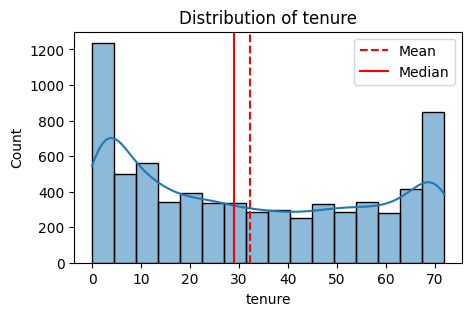

In [31]:
plot_histogram(df, "tenure")

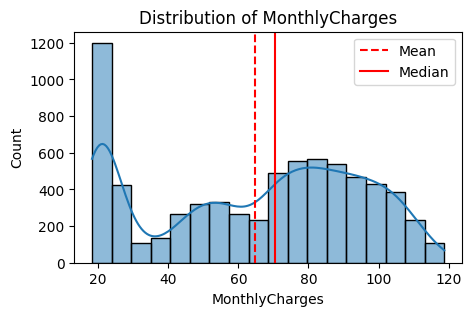

In [32]:
plot_histogram(df, "MonthlyCharges")

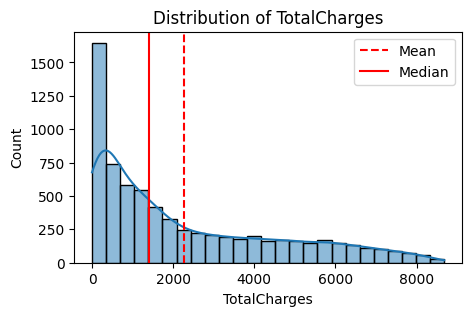

In [33]:
plot_histogram(df, "TotalCharges")

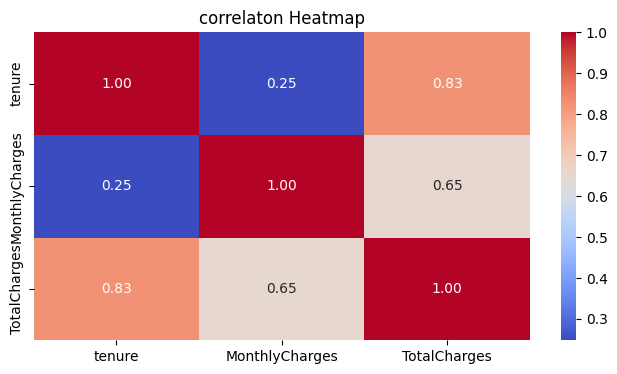

In [39]:
plt.figure(figsize = (8, 4))
sns.heatmap(df[["tenure", "MonthlyCharges", "TotalCharges"]].corr(), annot = True, cmap = "coolwarm", fmt = ".2f")
plt.title("correlaton Heatmap")
plt.show()

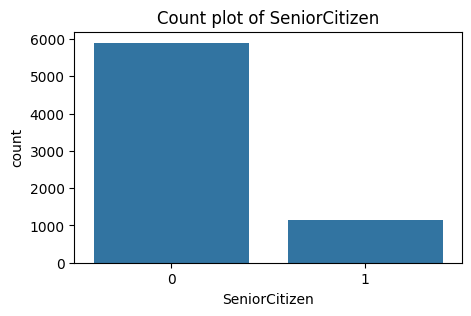

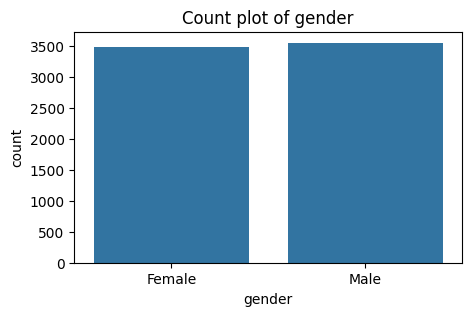

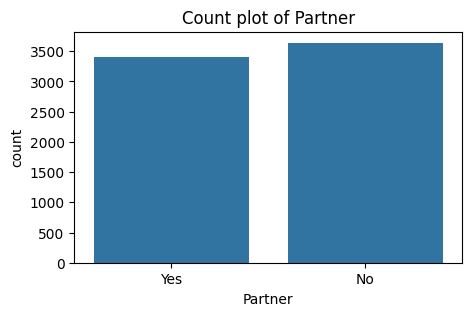

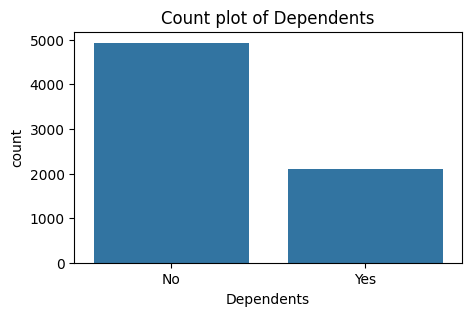

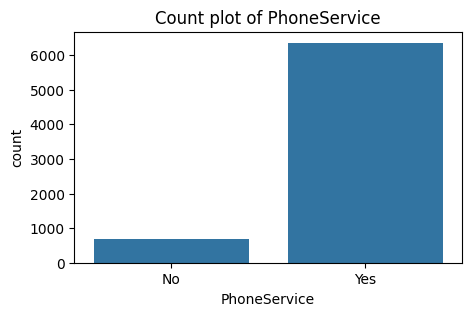

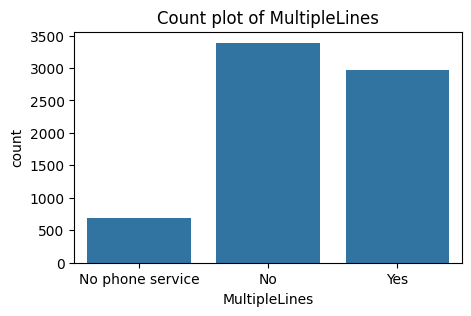

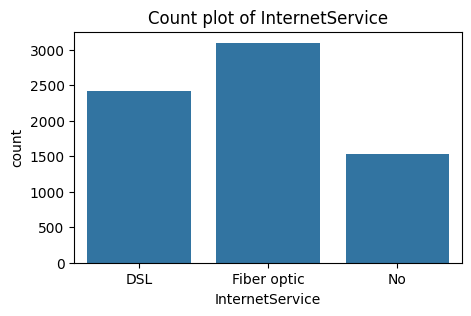

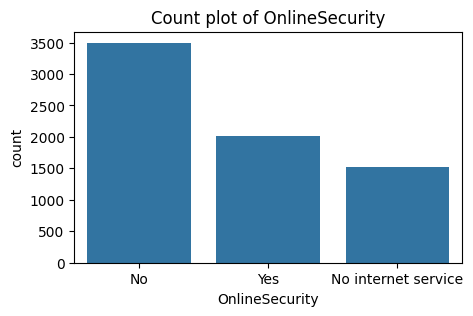

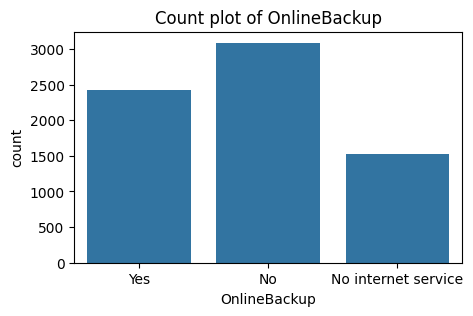

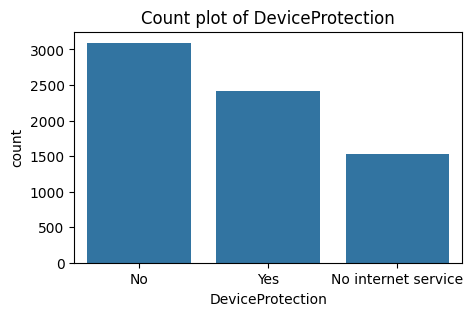

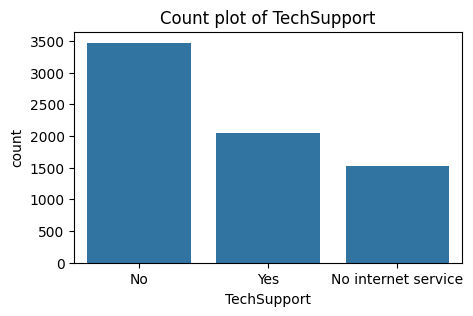

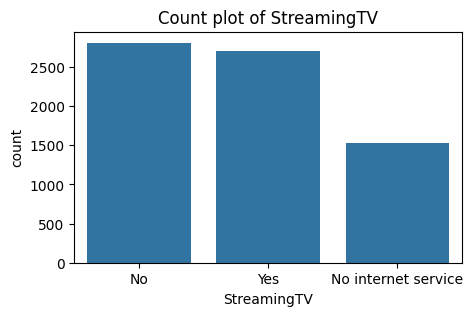

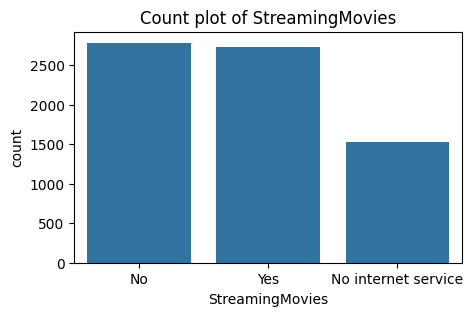

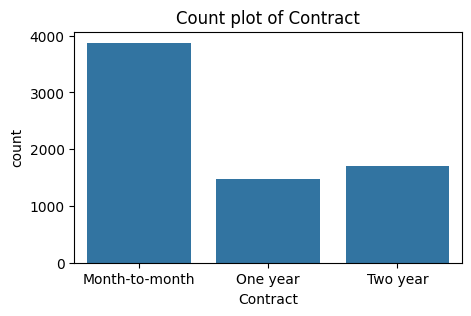

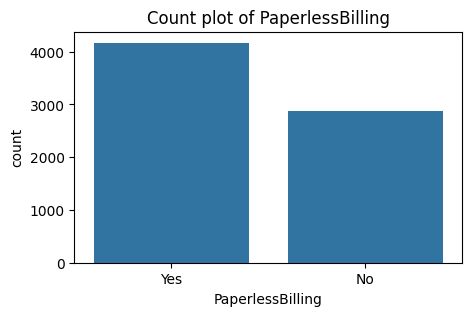

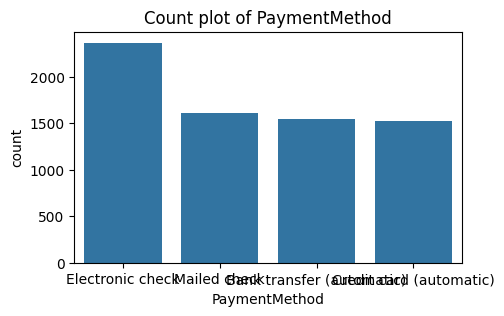

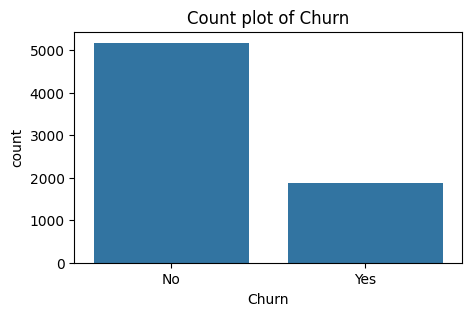

In [42]:
object_cols = df.select_dtypes(include = 'object').columns.to_list()

object_cols = ["SeniorCitizen"] + object_cols

for col in object_cols:
  plt.figure(figsize = (5, 3))
  sns.countplot(x = df[col])
  plt.title(f"Count plot of {col}")
  plt.show()

In [45]:
df["Churn"] = df["Churn"].replace({"Yes":1, "No":0})

<ipython-input-45-7e1dddaa2b81>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Churn"] = df["Churn"].replace({"Yes":1, "No":0})


In [46]:
object_columns = df.select_dtypes(include = "object").columns


In [49]:
import pickle

In [50]:
encoders = {}

for column in object_columns:
  label_encoder = LabelEncoder()
  df[column] = label_encoder.fit_transform(df[column])
  encoders[column] = label_encoder


with open ("encoders.pkl", "wb") as f:
  pickle.dump(encoders, f)

In [51]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [52]:
X = df.drop(columns = ["Churn"])
y = df["Churn"]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [54]:
y_train.value_counts()

,count
Churn,
0,4138
1,1496


In [55]:
smote = SMOTE(random_state = 42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

y_train_smote.shape

(8276,)

In [62]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state = 42),
    "Random Forest": RandomForestClassifier(random_state = 42),
    "XGBoost": XGBRFClassifier(random_state = 42)
}

In [65]:
cv_scores = {}
for model_name, model in models.items():
  scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring = "accuracy")
  cv_scores[model_name] = scores
  print(f"{model_name} cross_validation_accuracy: {np.mean(scores): .2f}")

Decision Tree cross_validation_accuracy:  0.78
Random Forest cross_validation_accuracy:  0.84
XGBoost cross_validation_accuracy:  0.81


In [67]:
cv_scores

{'Decision Tree': array([0.68297101, 0.71299094, 0.82175227, 0.83564955, 0.83564955]),
 'Random Forest': array([0.72524155, 0.77824773, 0.90513595, 0.89425982, 0.90090634]),
 'XGBoost': array([0.71799517, 0.77220544, 0.85498489, 0.83987915, 0.85135952])}

In [70]:
rfc = RandomForestClassifier(random_state = 42)

rfc.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [72]:
y_test_pred = rfc.predict(X_test)

print("Accuracy Score:\n", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Accuracy Score:
 0.7785663591199432
Confusion Matrix:
 [[878 158]
 [154 219]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      1036
           1       0.58      0.59      0.58       373

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



In [78]:
#save the trained model as a pickle file
model_data = {"model": rfc, "features_names": X.columns.tolist()}
with open("customer_churn_model", "wb") as f:
  pickle.dump(model_data, f)

In [75]:
#Load the saved model and the label encoders

In [80]:
with open("customer_churn_model", "rb") as f:
  model_data = pickle.load(f)

loaded_model = model_data["model"]
features_names = model_data["features_names"]
